In [1]:
%load_ext autoreload
%autoreload 2

import sys
from utils import *
from MODIS import *
import warnings
warnings.filterwarnings('ignore')
from rpy2.robjects import numpy2ri
import numpy as np
import xarray as xr
import pandas as pd
numpy2ri.activate()
from IPython import display

R[write to console]: data.table 1.13.4 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following object is masked from ‘package:raster’:

    shift




In [2]:
# name of crop and dataset name to use
# names of alternative precipitation and radiation datasets to use
# set to 'None' to use the precip and radiation from the main dataset
crop = 'wheat'
datasetname = 'ukcp18'
precname = 'None'
radname = 'None'

# location of the driving data netcdf files. Must encompass the time range specified 
# Use wildcards to match all the required data files. '**' means every directory 
dataloc = "/data/UKCP18/RCM_12km/daily_timeseries/downloaded_data/**/*.nc"

# names of the driving data variables to use
varnames = ["pr", "tasmax", "tasmin", "rss", "tas"]

# location and filename of elevation data
# only used for grass crop currently
elevfile = 'None'

# location and filename of the csv file containing the CO2 concentration projections                                          
CO2file = '/users/sgsys/matbro/cropNET/data/UKCP18_CO2_RCP85.csv'

# location and filename of the AWC data
AWCrast = "/users/sgsys/matbro/cropNET/data/MaxWet1.tif"

# location to save outputted yields in                                                                                       
yieldsaveloc = '/users/sgsys/matbro/cropNET/outputs/'

# where to store the formatted driving data
saveloc = '/users/sgsys/matbro/cropNET/driving_datafiles'

# switch controlling plotting of outputs.
# 0: no plots, 1: 1 plot containing the timeseries at each iteration, 
# 2: 2 plots, one showing the value of the cost function at each iteration 
plot = 1
# output a plot every interval iterations, if saving the plots, the smaller
# this number is, the slower the code will run. The slowdown when not saving
# plots is smaller, but still a thing
interval = 50
# directory to store plots in. Set to 'None' to not save plots. 
# Saving plots makes the code significantly slower.
# Ignored if plot==0.
plotdir = 'None'

# verify switch. If set to 1, the code will run for all the locations for which we                                            
# have precision yield data, and produce plots comparing the original modelled                                                
# yield to that after assimilation. The yield data is read in from the                                                        
# yieldshapefile.                                                                                                             
# As there are ~1300 fields of precision yield data, the code will take a few days                                            
# to run. To reduce this time, change the number of precision yield locations we                                              
# run for in howmanyobs below.                                                                                                
verify = 0
howmanyobs = -1 # set to -1 for all                                                                                           
yieldshapefile='/users/sgsys/matbro/data/cropyield/Mean_wheat_yields_v2/mean_wheat_yields_OSGB.shp'

# obs switch. Set to 1 to download MODIS LAI, 2 to use already downloaded data,                                               
# option 1 uses the coords specified below                                     
obs = 2

# directory containing MODIS LAI data, or location to download it to                                                              
# Ignored if obs==0                                                                                                           
# Note that all files in this directory will be used, regardless                                                              
# of whether they are newly downloaded or not.                                                                                
# Create separate directories for different sets of locations                                                                 
MODISdir = '/users/sgsys/matbro/cropNET/data/MODIS/test/'

# Coordinates to run over. Alternatively, a csv file with one x,y coord per line can                                          
# be specfied in coordsfile. Set coordsfile to None to use obscoords.                                                         
# Both ignored if verify==1                                                                                                   
#             x     , y                                                                                                       
coords = [[580000, 300000], # E Anglia                                                                                     
          [460000, 420000], # C. Eng                                                                                       
          [260000,  90000]] # SW. Eng                                                                               
coordsfile = None

In [3]:
# UKCP18 ensemble members to use. Note that '02', '03' and '14' don't exist.                                                  
# Note that because the error in the modelled value is based on the ensemble                                                  
# spread, reducing the number of ensemble members used will result in the                                                     
# assimilated/optimum GAI being closer to the original modelled GAI.                                                          
# To counteract this, change the moderrinfl variable below. You may need to                                                   
# experiment a bit to get the results you want!                                                                               
ensmems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']

# timespan of year to run for                                            
startyear = 2014
startmonth = 10
startday = 1
endyear = 2015
endmonth = 9
endday = 30

# Assimilation controls:                                                                                                      
obserrtype = 0 # if 1, obsstd = obs*obserr for each tstep (relative)                                                          
               # if 0, obsstd = obserr for each tstep (actual)                                                                
obserr = 0.1 # the obs stdev to assume (either relative or actual)                                                            
moderrinfl = 1 # factor to multiply the model error by                

# maximum value by which the optimum/assimilated timeseries should not change by more than                                    
# for one timestep to the next in the smoothed timeseries in the smoothing constraint.                                        
# See README for more details                                                                                                 
tsvar=0.25
# To smooth the timeseries based on 1st order or 2nd, 3rd... order differences.                                               
# 1st order seems to work best                                                                                                
order=1
# The strength of the smoothing. The higher this is, the smoother the timeseries                                              
# will be that the smoothing component of the cost function is trying to push the                                             
# optimum/assimilated timeseries to.                                                                                          
power=10

In [4]:
##########################################################################################                                    
# Main code:                                                                                                                  
#                                                                                                                             
##########################################################################################                                    

r['source']('Lynch_potpredict_v2_MJB.R')                                                                                      
GAIfunc_p = r['GAI_point']

# use yield shape file to generate locations to request MODIS data for if verify mode                                         
if verify==1 and obs==1:
    datacodes = MODIS_request(yieldshapefile, coords, startyear, endyear, MODIScode='MCD15A2H')
    MODIS_download(MODISdir, datacodes, product_name='Lai_500m')

# otherwise use provided x,y coords                                                                                           
if verify==0 and obs==1:
    datacodes = MODIS_request(coordsfile, coords, startyear, endyear, MODIScode='MCD15A2H')
    MODIS_download(MODISdir, datacodes, product_name='Lai_500m')

print('Processing obs')
obspdall, coords = MODIS_process(os.path.join(MODISdir, '*.csv*'))

if verify==1:
    #obspdall = obspdall.iloc[:, :howmanyobs]
    #obscoords = obscoords[:howmanyobs]
    obspdall = obspdall.iloc[:, :howmanyobs]
    coords = coords[:howmanyobs]

Processing obs
Processing 1 of 3
Processing 2 of 3
Processing 3 of 3


In [5]:
r['source']('Lynch_potpredict_v2_MJB.R')                                                                                                     
GAIfunc_p = r['GAI_point']

cfyears_vari = []
# create xr datasets to store yield                                                                                    
ensmemsint = [int(ensmem) for ensmem in ensmems]
oldyields_dict = {}
newyields_dict = {}
for tob in coords:
    oldyields_dict[str(tob[0])+','+str(tob[1])] = xr.DataArray(np.zeros((len(ensmems), 1)), coords=[ensmemsint, [endyear]], dims=['ensmem', 'year'])
    newyields_dict[str(tob[0])+','+str(tob[1])] = xr.DataArray(np.zeros((len(ensmems), 1)), coords=[ensmemsint, [endyear]], dims=['ensmem', 'year'])
oldyields_vari = xr.Dataset(oldyields_dict)
newyields_vari = xr.Dataset(newyields_dict)

startmonthstr = '{:02.0f}'.format(startmonth)
startdaystr = '{:02.0f}'.format(startday)
endmonthstr = '{:02.0f}'.format(endmonth)
enddaystr = '{:02.0f}'.format(endday)


# extract out a year's worth of obs                                                                                   
gyeardates = xr.cftime_range(str(startyear)+ '-' + str(startmonthstr) + '-' + str(startdaystr), 
                             str(endyear)+ '-' + str(endmonthstr) + '-' + str(enddaystr), 
                             calendar='360_day', freq='D', name='date').values
try:
    obspd = obspdall.loc[gyeardates]
except KeyError:
    print('Required times not present in downloaded MODIS data, re-run code with obs=1 to download')
times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])

if plotdir != 'None':
    if not os.path.exists(plotdir):
        os.makedirs(plotdir)

GAI_p_all, GAI_p_ensmean, GAI_p_ensstd, \
tmean_p_all, prec_p_all, solarrad_p_all, \
Jarray_p_all, Cday_p_all, GSS_p_all, \
HarvestJday, AWC_allp, CDD, TT, temp_cconc = \
ensgen_point(ensmems, times, datasetname, precname, radname, crop, coords, 
             dataloc, saveloc, AWCrast, elevfile, CO2file)

Generating ensemble data
Ensemble 01
Producing subsetted driving data nc file(s):
Processing pr
Processing tasmax
Processing tasmin
Processing rss
Processing tas
Saving all variables
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1.4s
Reading in driving data from file
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Calculating GAI at each coord
Calculating GAI for ensmem 01 for obs 1 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] "Precip: mm"
[1] "Solar rad: W/m^2"
Calculating GAI for ensmem 01 for obs 2 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] "Precip: mm"
[1] "Solar rad: W/m^2"
Calculating GAI for ensmem 01 for obs 3 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] 

Processing tasmin
Processing rss
Processing tas
Saving all variables
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1.2s
Reading in driving data from file
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Calculating GAI at each coord
Calculating GAI for ensmem 11 for obs 1 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] "Precip: mm"
[1] "Solar rad: W/m^2"
Calculating GAI for ensmem 11 for obs 2 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] "Precip: mm"
[1] "Solar rad: W/m^2"
Calculating GAI for ensmem 11 for obs 3 of 3
[1] "Using UKCP18 data, units:"
[1] "Temperature: Celsius"
[1] "Precip: mm"
[1] "Solar rad: W/m^2"
Ensemble 12
Producing subsetted driving data nc file(s):
Processing pr
Process

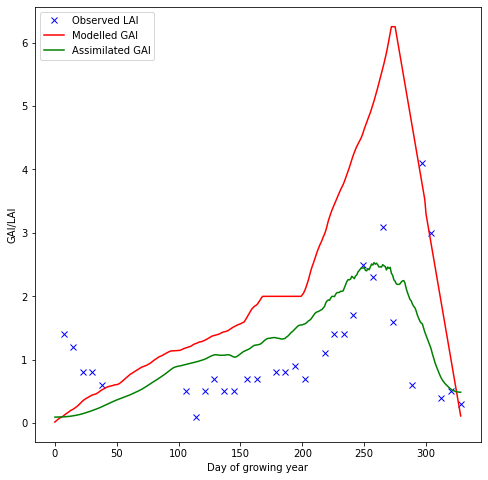

         Current function value: 5280.725102
         Iterations: 327
         Function evaluations: 519
         Gradient evaluations: 507
Processing obs point 1 of 3
Processing obs point 2 of 3
Processing obs point 3 of 3
Saving to netcdf


<Figure size 432x288 with 0 Axes>

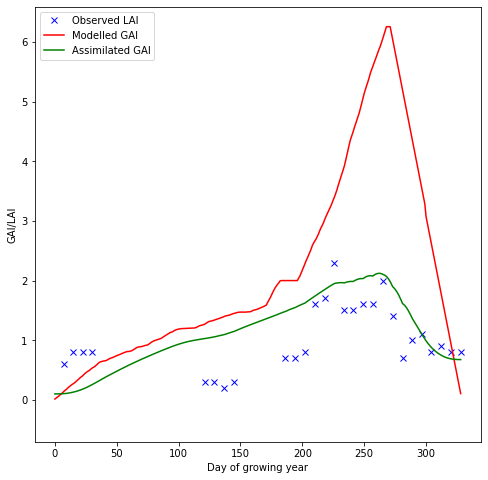

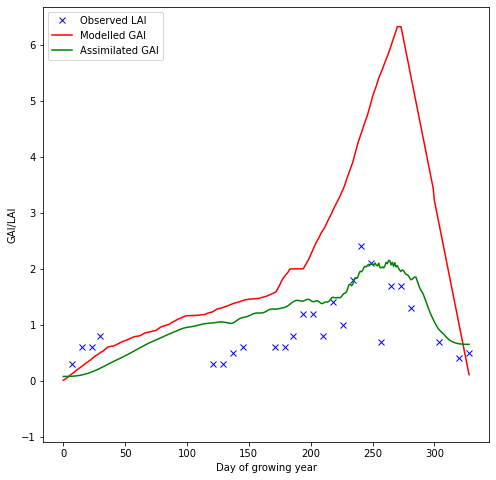

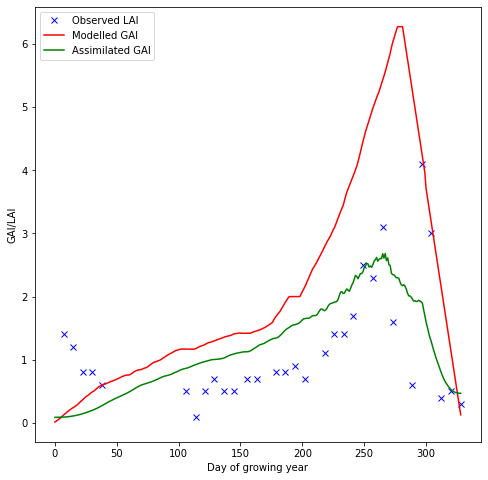

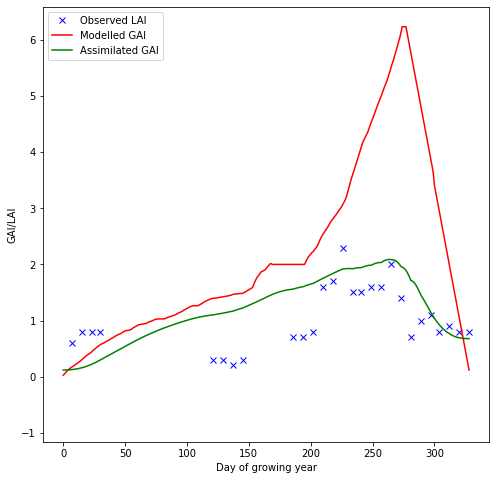

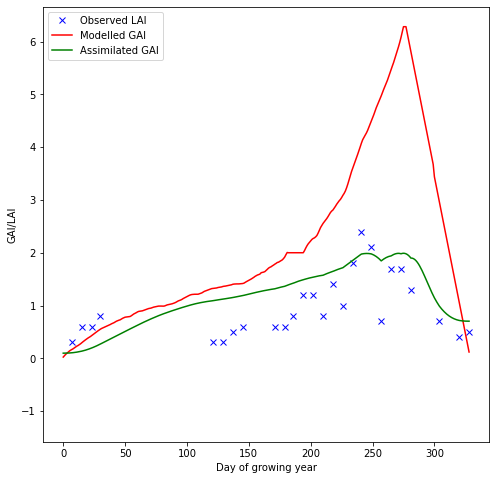

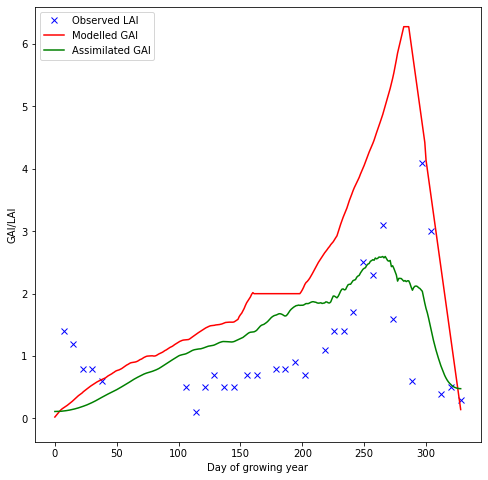

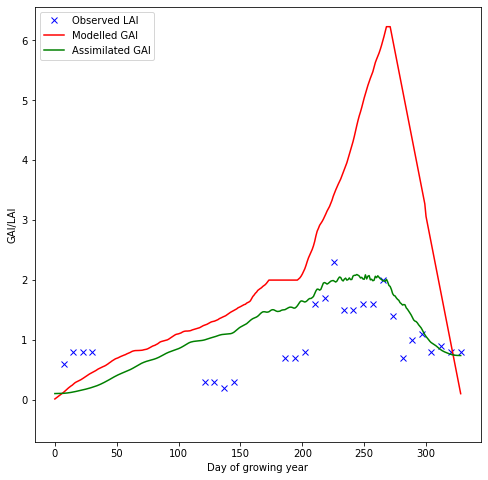

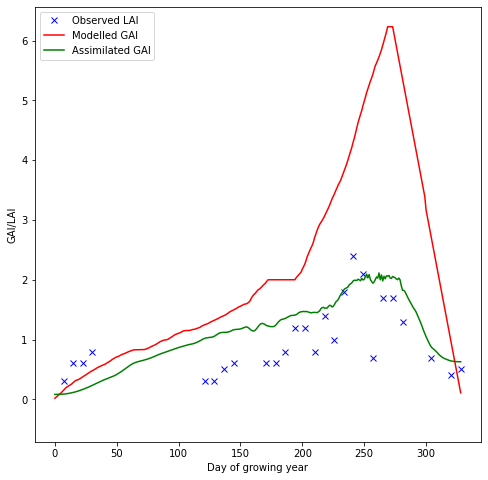

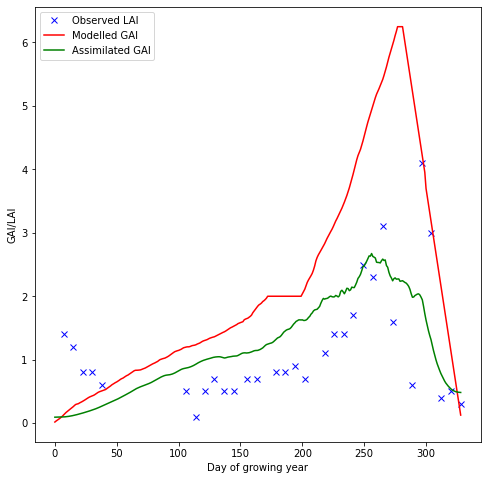

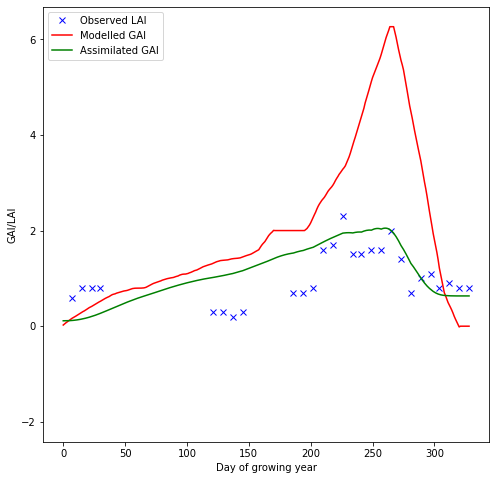

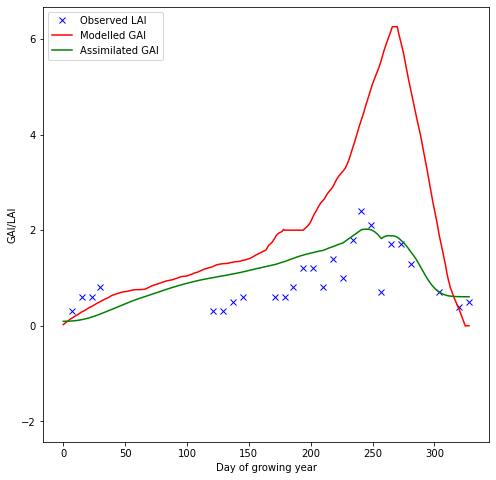

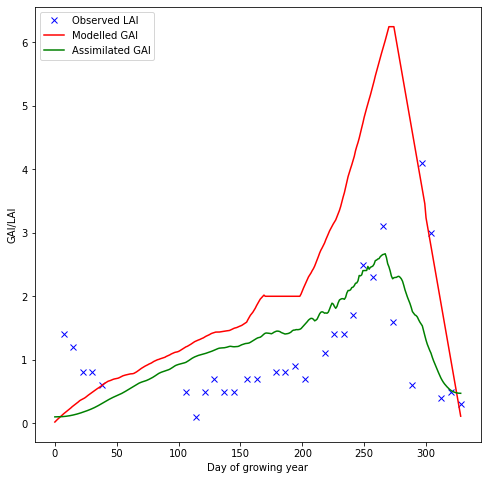

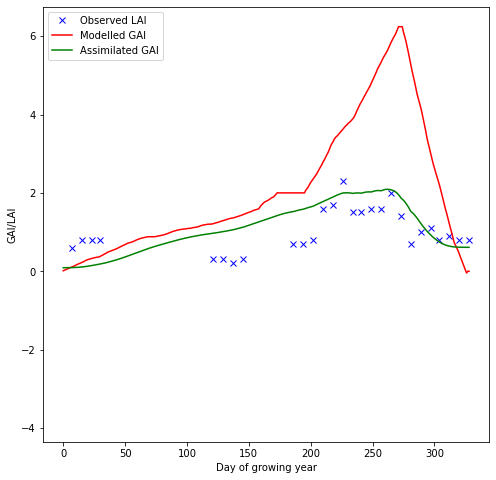

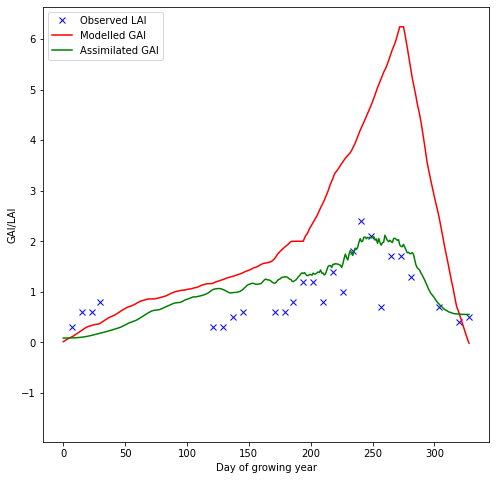

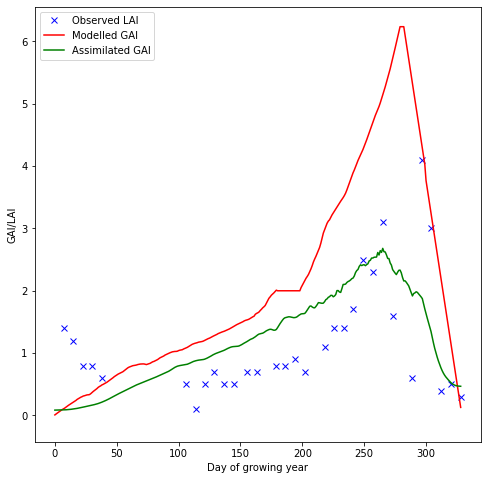

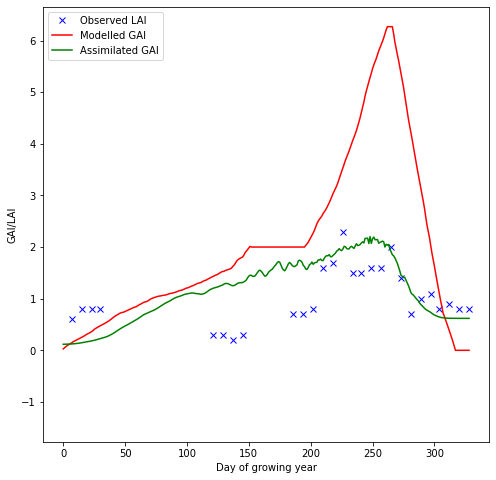

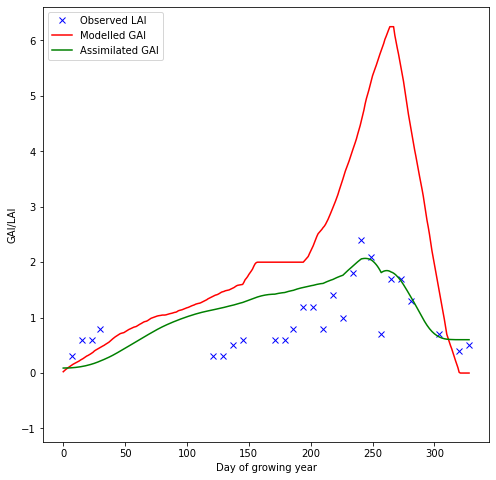

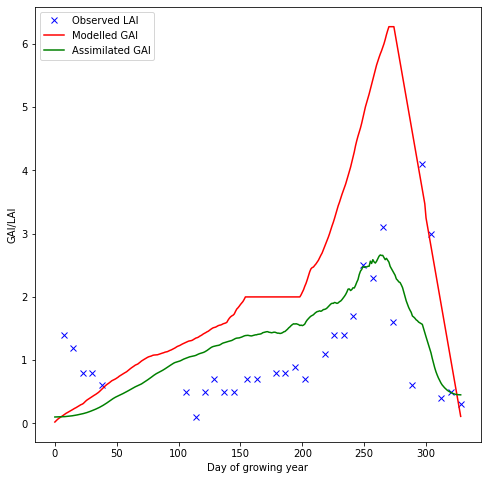

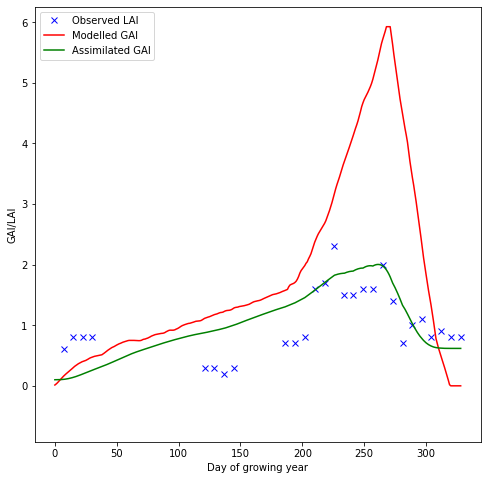

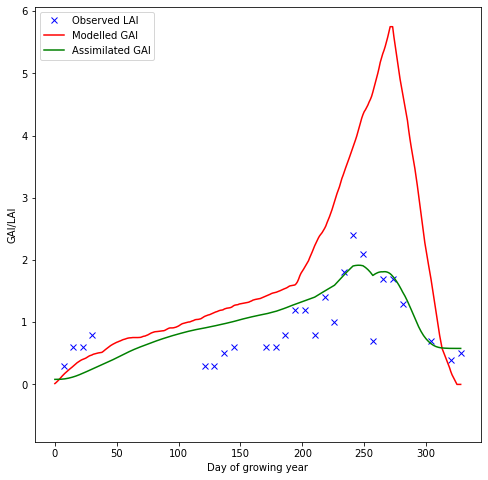

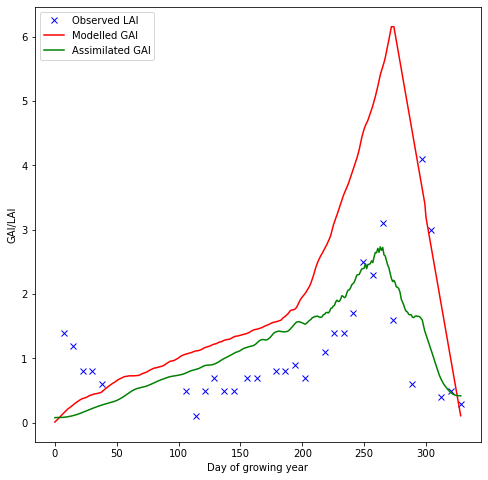

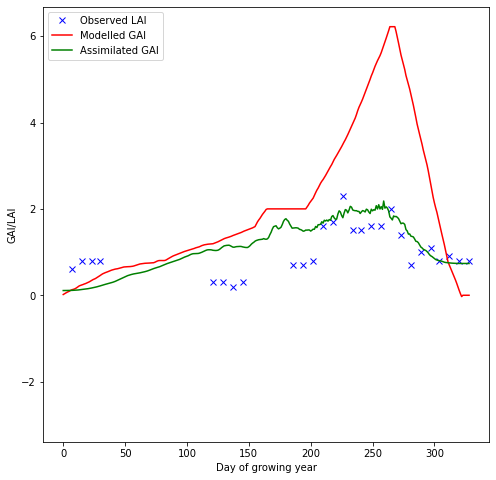

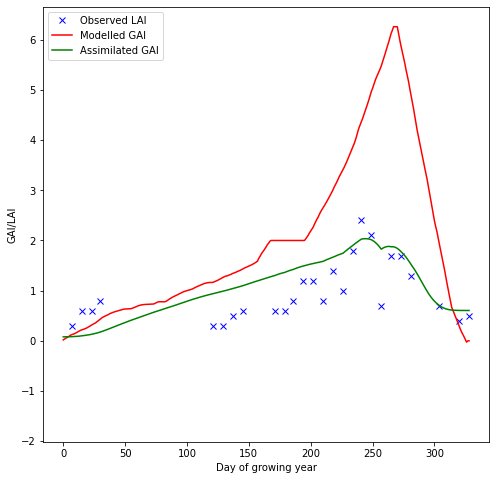

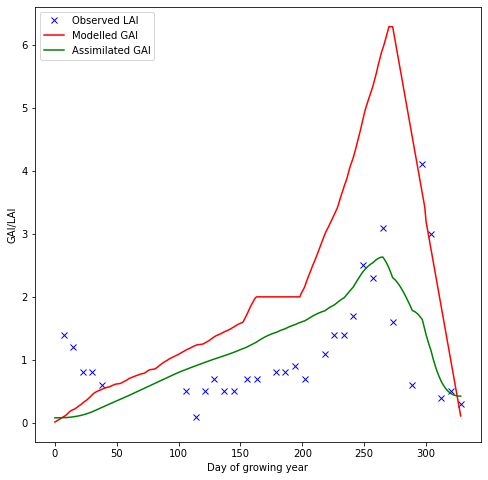

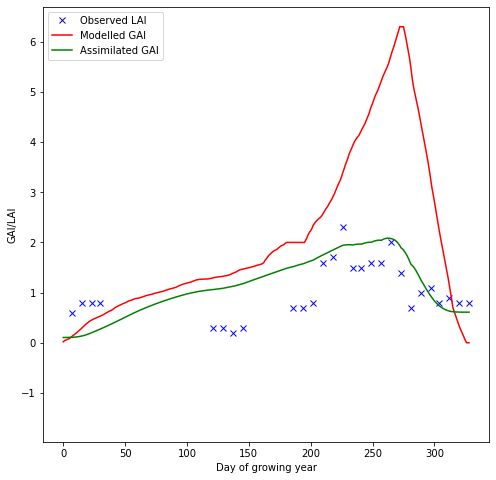

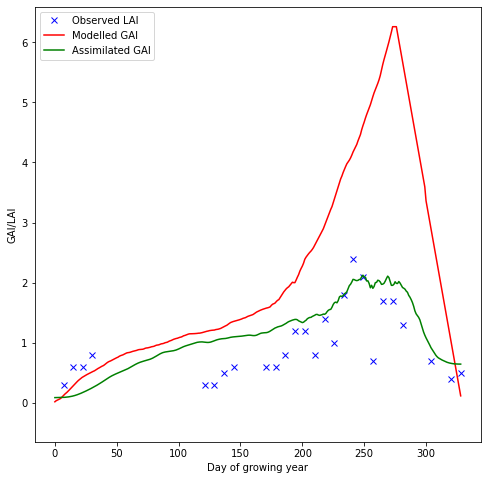

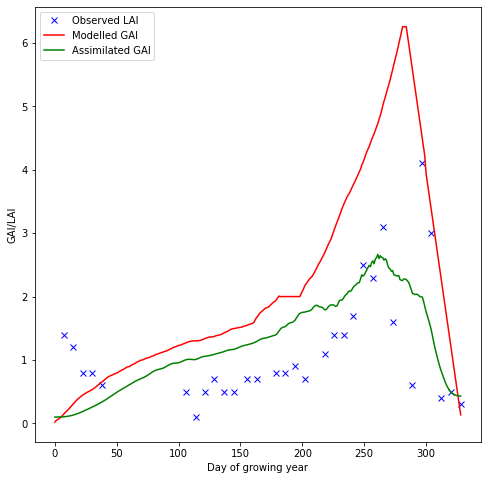

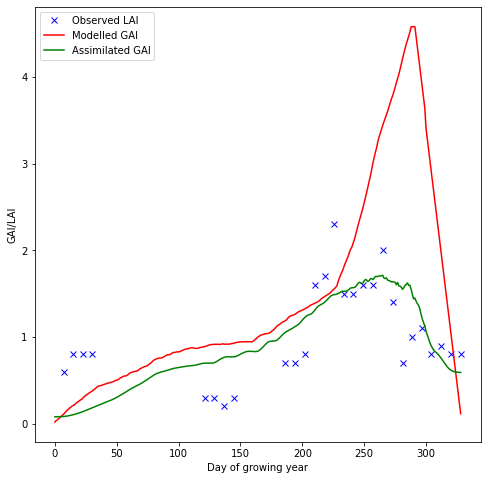

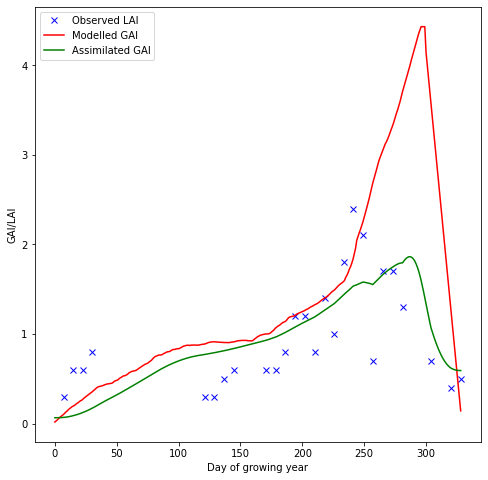

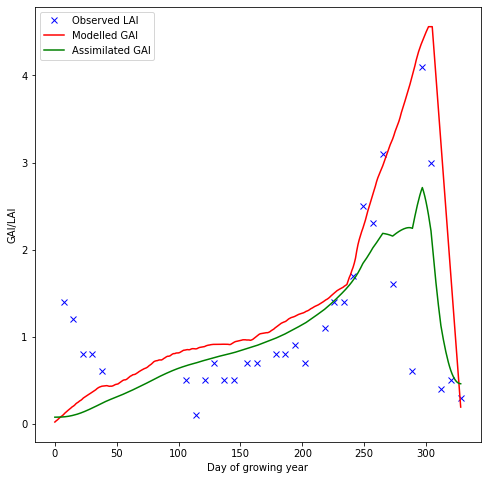

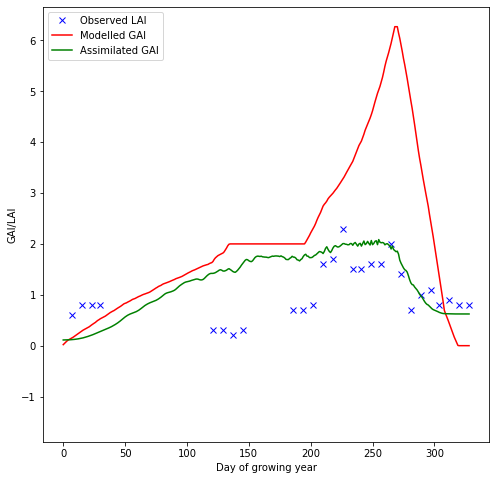

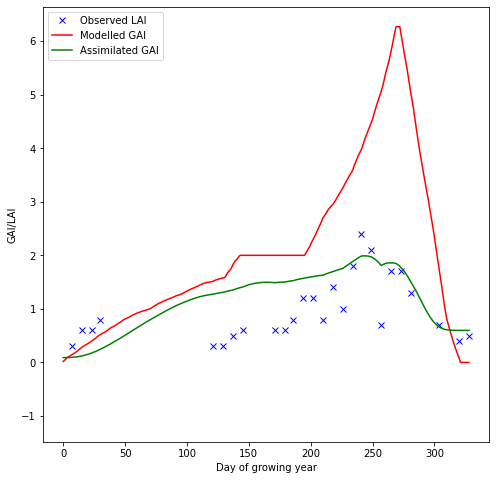

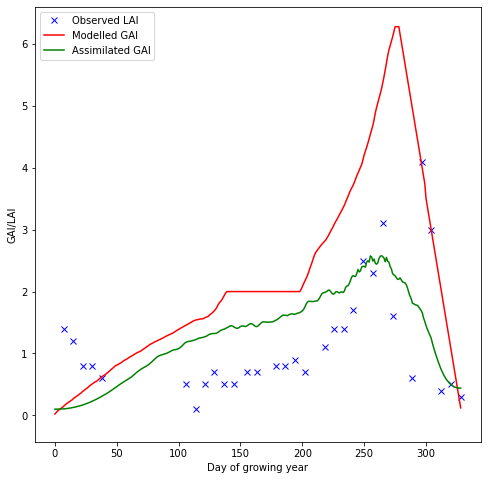

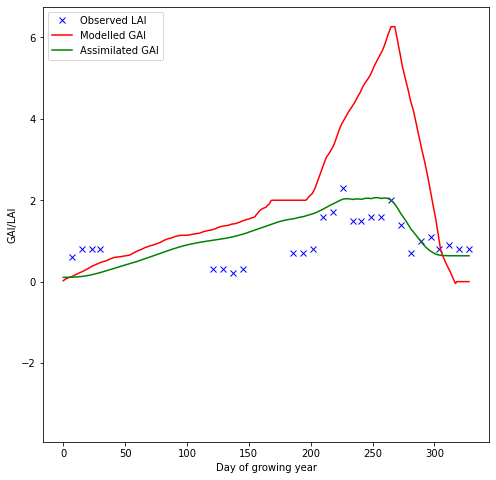

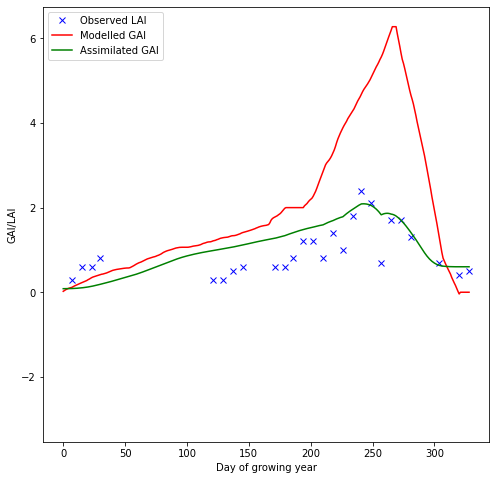

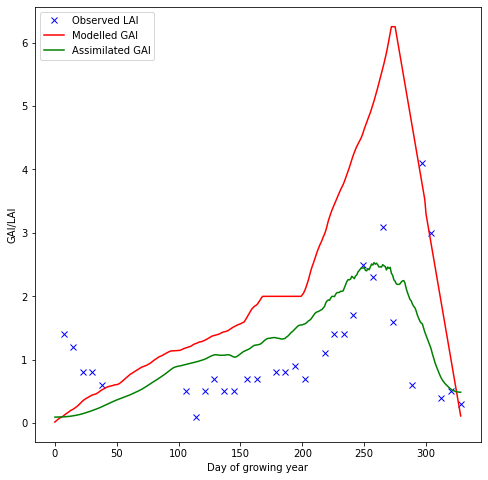

In [6]:
# now we've done the ensgen, do the assimilation                                                                      
cfxrs_vari = []
for ensmem in ensmems:
    print('Doing DA for GAI using variational method for ensmem ' + ensmem)
    mergedall_vari, cfall_vari = vari_method_point(obspd, GAI_p_all.sel(ensmem=int(ensmem)), GAI_p_ensstd,
                                                   coords, endyear, ensmem, obserrtype, obserr, moderrinfl, 
                                                   tsvar, order, power, plot, plotdir, interval)

    cfxr_vari = cfall_vari.to_xarray()
    del cfall_vari
    cfxr_vari = cfxr_vari.expand_dims({'ensmem': [int(ensmem)]})
    cfxr_vari = xr.where(np.isinf(cfxr_vari), np.nan, cfxr_vari) # set infs as nans                                   
    cfxrs_vari.append(cfxr_vari)
    
    oldyields, newyields = update_yield_points_point(GAI_p_all.sel(ensmem=int(ensmem)), mergedall_vari, coords,
                                 tmean_p_all.sel(ensmem=int(ensmem)), prec_p_all.sel(ensmem=int(ensmem)),
                                 solarrad_p_all.sel(ensmem=int(ensmem)), Jarray_p_all.sel(ensmem=int(ensmem)),
                                 Cday_p_all.sel(ensmem=int(ensmem)), GSS_p_all.sel(ensmem=int(ensmem)),
                                 HarvestJday, AWC_allp, CDD, TT, temp_cconc, ensmem)

    del mergedall_vari
    counter=0
    for tob in coords:
        oldyields_vari[str(tob[0])+','+str(tob[1])].loc[dict(ensmem=int(ensmem), year=endyear)] = oldyields[counter]
        newyields_vari[str(tob[0])+','+str(tob[1])].loc[dict(ensmem=int(ensmem), year=endyear)] = newyields[counter]
        counter+=1
        
    #cfallensmems_vari = xr.concat(cfxrs_vari, dim='ensmem')
    #cfyears_vari.append(cfallensmems_vari)
    
#print('Calculating climatological conversion factor using years: ' + str(years) + '\n')
#cfallyears_vari = xr.concat(cfyears_vari, dim='date')
#del cfyears_vari
#cfensmean_vari = cfallyears_vari.mean(dim='ensmem')
#del cfallyears_vari
#cfclim_vari = cfensmean_vari.groupby('date.dayofyear').mean().roll(dayofyear=-270, roll_coords=True)

print('Saving to netcdf')
if not os.path.exists(yieldsaveloc):
    os.makedirs(yieldsaveloc)
now = dt.datetime.now().strftime('%Y%m%d%H%M%s')[:14]
oldyieldfile = os.path.join(yieldsaveloc, now + '_oldyield.nc')
newyieldfile = os.path.join(yieldsaveloc, now + '_newyield.nc')
#cfclimfile   = os.path.join(yieldsaveloc, now + '_cfclimo.nc')
oldyields_vari.to_netcdf(oldyieldfile)
newyields_vari.to_netcdf(newyieldfile)
#cfclim_vari.to_netcdf(cfclimfile)